In [165]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Загрузка датасета

In [166]:
df = pd.read_csv('processed_data.csv')
df

,date,AAPL,AMD,AMZN,CSCO,META,MSFT,NFLX,QCOM,SBUX,TSLA
0,2013-07-19,-0.015765,-0.131466,0.003683,-0.001547,-0.011421,-0.113995,-0.006884,0.005645,0.004527,0.005469
1,2013-07-22,0.003202,-0.032258,-0.005733,-0.003873,0.006337,0.019427,-0.009890,0.012203,0.003344,0.022974
2,2013-07-23,-0.017175,-0.061538,-0.007974,-0.006221,0.003264,-0.005936,-0.044663,0.001447,-0.019704,0.002536
3,2013-07-24,0.051364,-0.008197,-0.007042,0.001174,0.014543,0.004400,-0.035803,-0.014607,-0.015519,-0.008481
4,2013-07-25,-0.004564,0.019284,0.014919,-0.003517,0.296077,-0.017835,0.022546,0.033067,0.023420,0.019474
...,...,...,...,...,...,...,...,...,...,...,...
2510,2023-07-11,-0.002810,-0.019898,0.012979,0.014008,0.014247,0.001929,-0.003396,-0.002135,0.009684,0.000668
2511,2023-07-12,0.008986,0.029285,0.015686,-0.026477,0.037044,0.014227,0.008723,0.015487,0.010491,0.008154
2512,2023-07-13,0.004058,0.011695,0.026758,0.015570,0.013157,0.016192,0.014255,0.037412,0.004548,0.021729
2513,2023-07-14,0.000787,0.000173,0.002829,-0.022317,-0.014486,0.007529,-0.018806,-0.004548,0.000098,0.012522


In [167]:
returns = df.iloc[:, 2:].dropna().values
dates = pd.to_datetime(df['date']).values[:len(returns)]

# Общие параметры для online-обучения
window_size    - размер скользящего окна
n_init         - размер начального набора данных для предобучения модели
risk_free_rate - доходность безрисковых активов
n_clusters     - колличество кластеров для типов валатильности рынка

In [ ]:
window_size = 10 
n_init = 30
risk_free_rate = 0.001
n_clusters = 3

# Функции обучения пифа
Использован принцип градиентного подъема



In [ ]:
import numpy as np
from scipy.stats import norm

def project_simplex(v):
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0)

def solve_pif(R_window, r, lr=0.1, iters=200):
    mu = np.mean(R_window, axis=0)
    Sigma = np.cov(R_window.T)
    n = mu.shape[0]

    def f(w):
        A = w @ mu - r
        B = np.sqrt(w @ Sigma @ w)
        return A / B

    def grad_f(w):
        A = w @ mu - r
        S = Sigma @ w
        B = np.sqrt(w @ Sigma @ w)
        return mu / B - A * S / (B ** 3)

    w = np.ones(n) / n
    best_w = w.copy()
    best_val = f(w)

    for _ in range(iters):
        g = grad_f(w)
        w = w + lr * g
        w = project_simplex(w)
        val = f(w)
        if val > best_val:
            best_val = val
            best_w = w.copy()

    best_p = norm.cdf(best_val)
    return best_w, best_p


# Функция создания расшиненого набора признаков
Расширенный набор признаков применяется для кластеризации по типу валатильности рынка

In [170]:
def make_features(R_window):
    flat = R_window.flatten()
    mean = R_window.mean(axis=0)
    std  = R_window.std(axis=0)
    mom  = R_window[-1] - R_window[0]
    return np.hstack([flat, mean, std, mom])

# Создание модели агента и предобучение

In [ ]:
all_feats = []
for t in range(window_size, len(returns) - window_size):
    R_w = returns[t-window_size:t]
    all_feats.append(make_features(R_w))
all_feats = np.array(all_feats)

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(all_feats)
cluster_labels = kmeans.labels_.reshape(-1, 1)

ohe = OneHotEncoder(sparse_output=False, categories='auto')
cluster_ohe = ohe.fit_transform(cluster_labels)

scaler = StandardScaler()
agent_model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=1e-4,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    average=True,
    max_iter=1,
    warm_start=True,
    random_state=0
)

X_init, y_init = [], []
for i, t in enumerate(range(window_size, window_size + n_init)):
    R_window = returns[t-window_size:t]
    w_pif, _ = solve_pif(R_window, risk_free_rate)
    y_pif = returns[t+1] @ w_pif
    stable = int(y_pif >= risk_free_rate)

    feat = make_features(R_window)
    feat = np.hstack([feat, cluster_ohe[i]])
    X_init.append(feat)
    y_init.append(stable)

X_init = scaler.fit_transform(X_init)
agent_model.fit(X_init, y_init)

/home/leshka/prog/python/course_work/work/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(average=True, eta0=0.01, learning_rate='invscaling',
              loss='log_loss', max_iter=1, power_t=0.25, random_state=0,
              warm_start=True)

# Online обучение моделей

In [ ]:
regrets, portfolio_returns, agent_returns, stability_checks = [], [], [], []
cum_reg = 0
opt_loss = np.inf

for idx, t in enumerate(range(window_size + n_init, len(returns) - window_size - 1)):
    R_window = returns[t-window_size:t]
    w_pif, _ = solve_pif(R_window, risk_free_rate)
    y_pif = returns[t+1] @ w_pif
    

    portfolio_returns.append(y_pif)
    stable = int(y_pif >= risk_free_rate)
    stability_checks.append(stable)

    feat = make_features(R_window)
    cluster_idx = t - window_size
    feat = np.hstack([feat, cluster_ohe[cluster_idx]])
    X_agent = scaler.transform(feat.reshape(1, -1))

    prob = agent_model.predict_proba(X_agent)[0, 1]
    x_ag = int(prob >= 0.5)
    agent_ret = prob * y_pif + (1 - prob) * risk_free_rate
    agent_returns.append(agent_ret)
    U_opt = max(y_pif, risk_free_rate)
    U_agent = prob * y_pif + (1-prob)*risk_free_rate

    step_reg = U_opt - U_agent
    cum_reg += step_reg
    regrets.append(cum_reg)

    agent_model.partial_fit(X_agent, [int(y_pif >= risk_free_rate)], classes=[0,1])

# Графики и аналитика

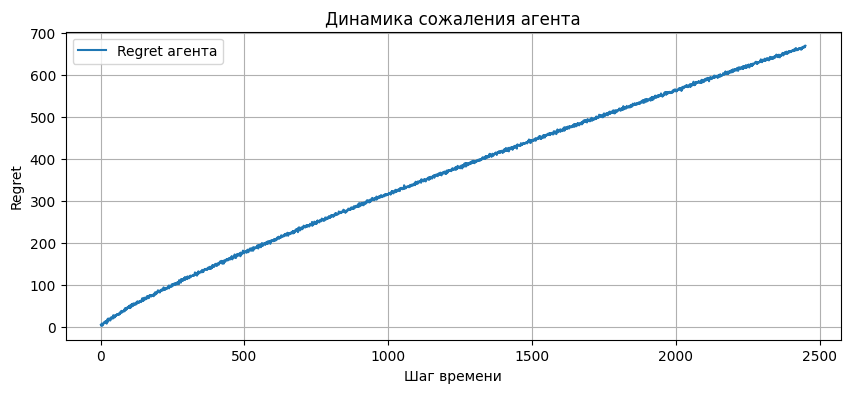

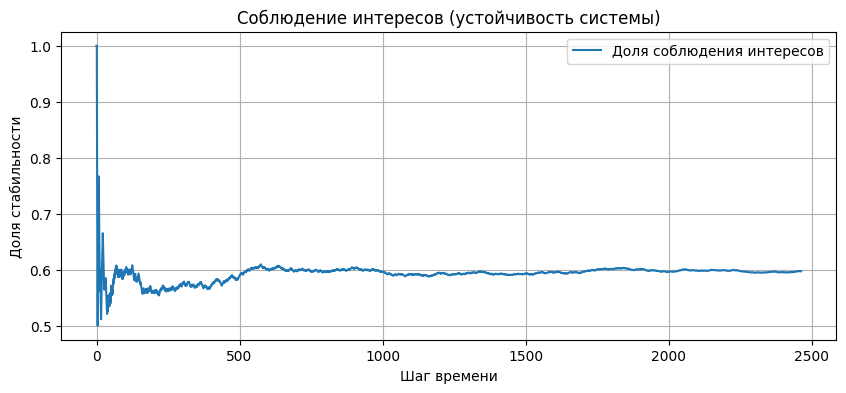

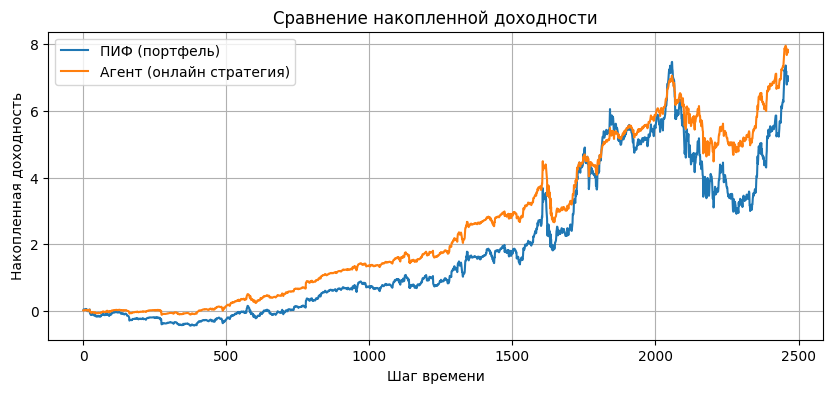

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(x, regrets, label="Regret агента")
plt.title("Динамика сожаления агента")
plt.xlabel("Шаг времени")
plt.ylabel("Regret")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(stability_checks)/np.arange(1,len(stability_checks)+1), label="Доля соблюдения интересов")
plt.title("Соблюдение интересов (устойчивость системы)")
plt.xlabel("Шаг времени")
plt.ylabel("Доля стабильности")
plt.grid(True)
plt.legend()
plt.show()

cum_portfolio_returns = np.cumprod(1 + np.array(portfolio_returns)) - 1
cum_agent_returns = np.cumprod(1 + np.array(agent_returns)) - 1

plt.figure(figsize=(10, 4))
plt.plot(cum_portfolio_returns, label="ПИФ (портфель)")
plt.plot(cum_agent_returns, label="Агент (онлайн стратегия)")
plt.title("Сравнение накопленной доходности")
plt.xlabel("Шаг времени")
plt.ylabel("Накопленная доходность")
plt.grid(True)
plt.legend()
plt.show()